In this notebook i'll be setting up an artificial dataset for the damped oscilator, then i'll use the deeponet as a surrogate model to do an inversion problem.

In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import optax

# Artificial dataset

Let's run the simulations for a set of points and then add some noise!

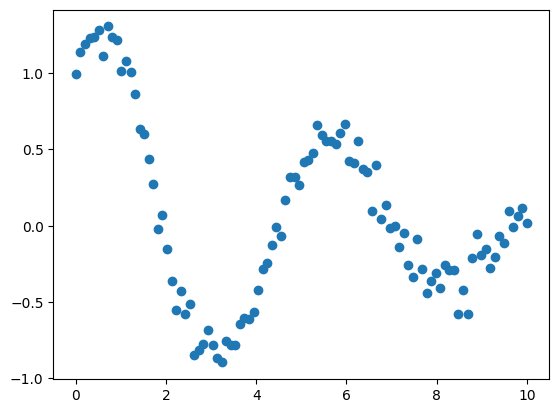

In [28]:
key = jax.random.key(42)

initial_cond = (1, 1)

def damped_oscillator_scipy(X, t, beta, k):
    x, v = X
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

ts = np.linspace(0, 10, 100)

beta = 0.3
k = 1.5

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))


ts = jnp.array(ts)
ys = jnp.array(solution[:, 0])
ys = ys + 0.1*jax.random.normal(key, shape=ys.shape)

plt.scatter(ts, ys)

Looks ugly enough for me! Let's go load the deeponet model.

# Model definition and loading

Let's redefine the model and load it.

In [2]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]


deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.relu,
    key=jax.random.key(463)
)
        
deeponet = eqx.tree_deserialise_leaves("best_model.eqx", deeponet)

# Inversion problem

Let's set up a loss function and update it using a simple. Let's set the initial conditions:

In [37]:
args = jnp.array(np.random.uniform(0, 2, size=(4,)))  
losses = []

In [39]:
ts = jnp.linspace(0, 10, 100).reshape(-1, 1)

def loss_fn(args):
    
    out = jax.vmap(deeponet, in_axes=(None, 0))(args, ts)
    delta = (out - ys)**2

    return jnp.mean(delta)

lr = 0.1

for it in range(1_000):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(args)

    losses.append(loss)
    args -= lr*grad
    
    if it % 10 == 0:
        print(f"{it = } | {loss = }")


it = 0 | loss = Array(0.21161015, dtype=float32)
it = 10 | loss = Array(0.1872308, dtype=float32)
it = 20 | loss = Array(0.18136562, dtype=float32)
it = 30 | loss = Array(0.17449181, dtype=float32)
it = 40 | loss = Array(0.16819488, dtype=float32)
it = 50 | loss = Array(0.16121288, dtype=float32)
it = 60 | loss = Array(0.15601787, dtype=float32)
it = 70 | loss = Array(0.15199876, dtype=float32)
it = 80 | loss = Array(0.14677942, dtype=float32)
it = 90 | loss = Array(0.13837582, dtype=float32)
it = 100 | loss = Array(0.12919933, dtype=float32)
it = 110 | loss = Array(0.12498116, dtype=float32)
it = 120 | loss = Array(0.12157268, dtype=float32)
it = 130 | loss = Array(0.11892755, dtype=float32)
it = 140 | loss = Array(0.11532318, dtype=float32)
it = 150 | loss = Array(0.10914864, dtype=float32)
it = 160 | loss = Array(0.10414024, dtype=float32)
it = 170 | loss = Array(0.10100005, dtype=float32)
it = 180 | loss = Array(0.07272771, dtype=float32)
it = 190 | loss = Array(0.06466171, dtype=f

In [40]:
args

Array([1.5094507 , 0.31676653, 0.99423313, 1.0538297 ], dtype=float32)

It worked!!! I can start refining it now.